In [249]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import uniform
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, roc_auc_score, roc_curve, mean_squared_error
# !pip install pyodbc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pyodbc

import random

In [92]:
random.seed()

# Data Cleaning

In [4]:
# upload the data
rawdf = pd.read_excel("XXH2021_YRBS_Data.xlsx")

In [5]:
df1 = rawdf[['q28', 'q10', 'q14', 'q15', 'q17', 'q19',
              'q3', 'q2', 'q20', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27',
            'q32', 'q35', 'q37', 'q38', 'q41', 'q47', 
             'q49', 'q52', 'q53', 'q56']].copy()

# df1['q67'] = df1['q67'].replace('NA', 4)

df1 = df1.dropna()

In [80]:
# df1

In [6]:
# Transform predictors based on the survey

df = pd.DataFrame()
# q28 -> suicide attempt
df['suicide attempt'] = df1['q28'].apply(lambda x: 1 if x >= 2 else 0)

# q10 -> DUI
df['any DUI'] = df1['q10'].apply(lambda x: 1 if x >= 3 and x <= 6 else 0)
df['many DUI'] = df1['q10'].apply(lambda x: 1 if x == 6 else 0)

# q15 -> weapon at school
df['weapon at school'] = df1['q15'].apply(lambda x: 1 if x >= 2 else 0)
df['unsafe school'] = df1['q15'].apply(lambda x: 1 if x >= 7 else 0)

# q14 -> unsafe absent
df['unsafe absent'] = df1['q14'].apply(lambda x: 1 if x >= 2 else 0)

# q17 -> school fight
df['school fight'] = df1['q17'].apply(lambda x: 1 if x >= 2 else 0)
df['frequent school fight'] = df1['q17'].apply(lambda x: 1 if x >= 7 else 0)

# q19 -> forced sex
df['forced sex'] = df1['q19'].apply(lambda x: 1 if x == 1 else 0)

# q3 -> grades
df['grade 9'] = df1['q3'].apply(lambda x: 1 if x == 1 else 0)
df['grade 10'] = df1['q3'].apply(lambda x: 1 if x == 2 else 0)
df['grade 11'] = df1['q3'].apply(lambda x: 1 if x == 3 else 0)
df['grade 12'] = df1['q3'].apply(lambda x: 1 if x == 4 else 0)

# q2-> gender
df['female'] = df1['q2'].apply(lambda x: 1 if x == 1 else 0)

# q20 -> sexual violence
df['sexual violence'] = df1['q20'].apply(lambda x: 1 if x >= 2 else 0)

# q22 -> physical dating violence
df['physical dating violence'] = df1['q22'].apply(lambda x: 1 if x >= 3 else 0)

# q23 -> school bully
df['school bully'] = df1['q23'].apply(lambda x: 1 if x == 1 else 0)

# q24 -> cyber bully
df['cyber bully'] = df1['q24'].apply(lambda x: 1 if x == 1 else 0)

# q25 -> hopeless
df['hopeless'] = df1['q25'].apply(lambda x: 1 if x == 1 else 0)

# q26 -> consider suicide
#df['consider suicide'] = df1['q26'].apply(lambda x: 1 if x == 1 else 0)

# q27 -> plan suicide
#df['plan suicide'] = df1['q27'].apply(lambda x: 1 if x == 1 else 0)

# q32 -> smoke
df['smoke'] = df1['q32'].apply(lambda x: 1 if x >= 2 else 0)

# q35 -> vape
df['vape'] = df1['q35'].apply(lambda x: 1 if x >= 2 else 0)

# q37 -> tobacco
df['tobacco'] = df1['q37'].apply(lambda x: 1 if x >= 2 else 0)

# q38 -> cigar
df['cigar'] = df1['q38'].apply(lambda x: 1 if x >= 2 else 0)

# q41 -> drink habit
df['drink habit'] = df1['q41'].apply(lambda x: 1 if x >= 5 else 0)

# q47 -> marijuana
df['marijuana'] = df1['q47'].apply(lambda x: 1 if x >= 2 else 0)

# q49 -> improper pain medicine
df['improper pain medicine'] = df1['q49'].apply(lambda x: 1 if x >= 2 else 0)

# q53 -> methamphetamines
df['methamphetamines'] = df1['q53'].apply(lambda x: 1 if x >= 2 else 0)

# q56 -> drug trade at school
df['school drug trade'] = df1['q56'].apply(lambda x: 1 if x == 1 else 0)


# Train-test split

In [7]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# 80-20 train-test split
X = df.drop('suicide attempt', axis=1)
y = df['suicide attempt']
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)

# Undersampling

In [8]:
# Separate the majority and minority classes
majority_class = train_data[train_data['suicide attempt'] == 0]
minority_class = train_data[train_data['suicide attempt'] == 1]

majority_undersampled = resample(majority_class,
                                  replace=False,
                                  n_samples=len(minority_class),
                                  random_state=42)

# Combine the undersampled majority class and the minority class to create the final training dataset
undersampled_train_data = pd.concat([majority_undersampled, minority_class])


X_train_undersampled = undersampled_train_data.drop('suicide attempt', axis=1)
y_train_undersampled = undersampled_train_data['suicide attempt']

# Summary statistics

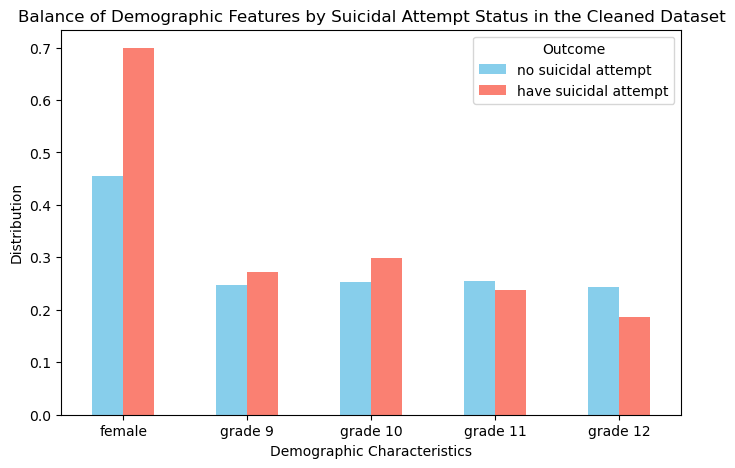

In [10]:
# Summary Statistics

# 1. Original cleaned Dataset

grouped = df[['suicide attempt', 'female', 'grade 9', 'grade 10', 'grade 11', 'grade 12']].groupby('suicide attempt').mean().T

ax = grouped.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])

ax.set_xticklabels(['female', 'grade 9', 'grade 10', 'grade 11', 'grade 12'], rotation=0)
ax.set_ylabel('Distribution')
ax.set_xlabel('Demographic Characteristics')
ax.set_title('Balance of Demographic Features by Suicidal Attempt Status in the Cleaned Dataset')

plt.legend(['no suicidal attempt', 'have suicidal attempt'], title='Outcome')

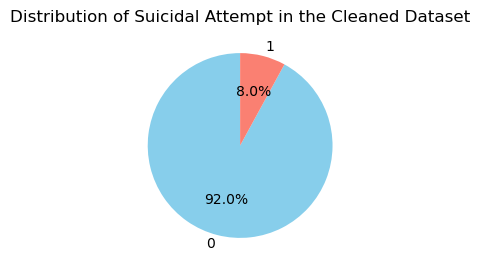

In [11]:
# pie chart on the outcome 
category_counts = df['suicide attempt'].value_counts()

# Create a pie chart
plt.figure(figsize=(3, 3))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])

plt.title('Distribution of Suicidal Attempt in the Cleaned Dataset')

plt.show()

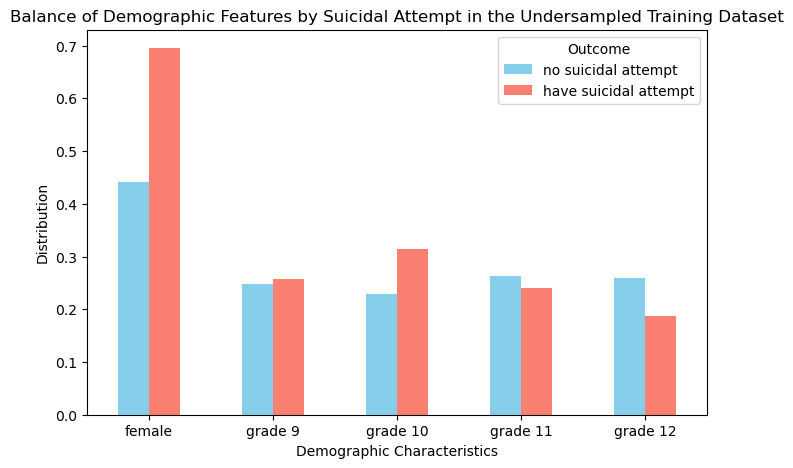

In [12]:
# 2. Undersampled Dataset

grouped2 = undersampled_train_data[['suicide attempt', 'female', 'grade 9', 'grade 10', 'grade 11', 'grade 12']].groupby('suicide attempt').mean().T

ax = grouped2.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])

ax.set_ylabel('Distribution')
ax.set_xlabel('Demographic Characteristics')
ax.set_xticklabels(['female', 'grade 9', 'grade 10', 'grade 11', 'grade 12'], rotation=0)
ax.set_title('Balance of Demographic Features by Suicidal Attempt in the Undersampled Training Dataset')

plt.legend(['no suicidal attempt', 'have suicidal attempt'], title='Outcome')

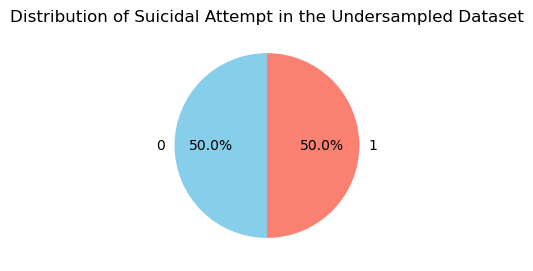

In [13]:
category_counts2 = undersampled_train_data['suicide attempt'].value_counts()

# Create a pie chart
plt.figure(figsize=(3, 3))
plt.pie(category_counts2, labels=category_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])

plt.title('Distribution of Suicidal Attempt in the Undersampled Dataset')

plt.show()

# Feature importance

In [14]:
undertclassifier = RandomForestClassifier()
undertclassifier.fit(X_train_undersampled, y_train_undersampled)
underscore = undertclassifier.score(x_test, y_test)

In [15]:
underscore

0.8010262257696693

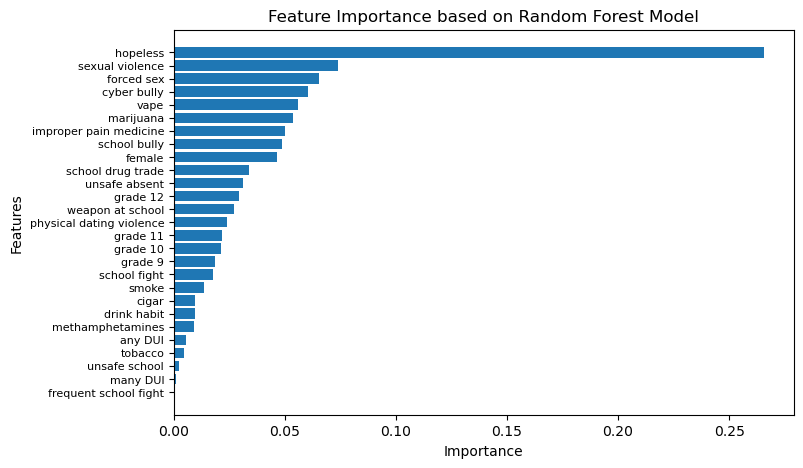

In [16]:
# Relative Importance
feature_names = train_data.columns 

paired_importances = list(zip(feature_names, undertclassifier.feature_importances_))
sorted_importances = sorted(paired_importances, key=lambda x: x[1], reverse=True)
snames, simportance = zip(*sorted_importances)

plt.figure(figsize=(8,5))
plt.barh(snames, simportance)
plt.tick_params(axis='y', labelsize=8)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance based on Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

# Classifiers

## Logistics Regression Classifier

In [251]:
# 1). Logistics Regression Classifier
logreg_classifier = LogisticRegression()
logreg_classifier.fit(X_train_undersampled, y_train_undersampled)
logreg_score = logreg_classifier.score(x_test, y_test)

In [252]:
logreg_score

0.7696693272519954

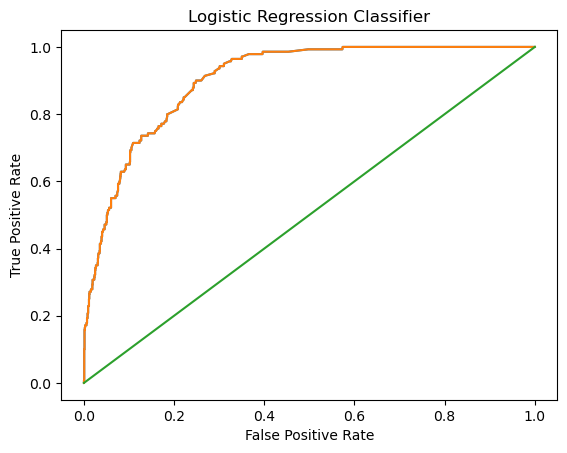

In [255]:
# ROC Curve 1
lr_predictions = logreg_classifier.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, lr_predictions[:, 1])
plt.plot(fpr, tpr)
plt.plot(fpr, tpr, fpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier')

# AUC score
lr_auc = roc_auc_score(y_test, lr_predictions[:, 1])

In [239]:
# Tuning to find the best hyperparameters
search_methods_lr = [
    (GridSearchCV, {'C': [0.01, 0.1, 1, 10, 100]}, {"cv": 3}),
    (RandomizedSearchCV, {'C': uniform(loc=0, scale=4)}, {"cv": 3, "n_iter":10})
]

search_res_lr = list()
best_params_lr = list()

for search_alg, params, kwargs in search_methods_lr:

    search = search_alg(logreg_classifier, params, **kwargs)
    search.fit(X_train_undersampled, y_train_undersampled)
    
    res = search.cv_results_
    search_res_lr.append(pd.DataFrame({
        "C Value": res["param_C"],
        "Mean CS Score": res["mean_test_score"]
    }).sort_values("C Value"))

    best_params_lr = search.best_params_

C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [240]:
best_params_lr

{'C': 0.4835308183967175}

In [241]:
# 3-fold cross validation using best paramaters
logreg_best = LogisticRegression(**best_params_lr)
log_scores = cross_val_score(logreg_best, X_train_undersampled, y_train_undersampled, cv=3, scoring='accuracy')

print("Cross-validated scores:", log_scores)
print("Average score:", log_scores.mean())

Cross-validated scores: [0.77150538 0.81451613 0.81182796]
Average score: 0.7992831541218637


## Random Forest Classifier

In [22]:
# 2). Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_scores = cross_val_score(rf_classifier, X_train_undersampled, y_train_undersampled, cv=kf)
print(f"Cross-validation accuracy scores: {rf_scores}")
print(f"Average accuracy: {rf_scores.mean():.2f}")

Cross-validation accuracy scores: [0.79032258 0.80645161 0.78225806]
Average accuracy: 0.79


In [23]:
rf_classifier.fit(X_train_undersampled, y_train_undersampled)
rf_score = rf_classifier.score(x_test, y_test)

In [24]:
rf_score

0.7919042189281642

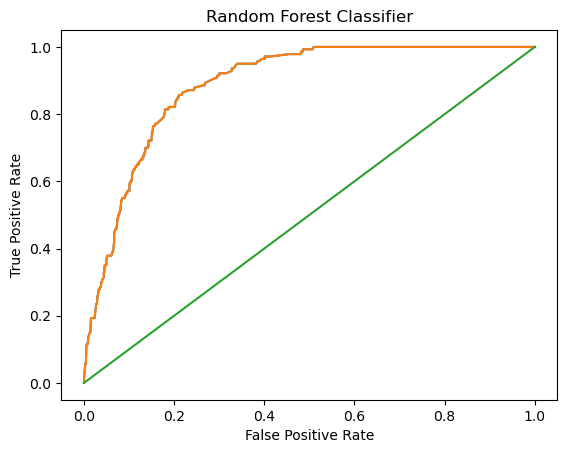

In [25]:
# ROC Curve 2
rf_predictions = rf_classifier.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, rf_predictions[:, 1])
plt.plot(fpr, tpr)
plt.plot(fpr, tpr, fpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier')

# AUC score
rf_auc = roc_auc_score(y_test, rf_predictions[:, 1])

In [125]:
# Tuning to find the best hyperparameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}

rf = RandomForestClassifier(random_state=482)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_undersampled, y_train_undersampled)

best_params_rf = grid_search.best_params_

In [126]:
best_params_rf

{'max_depth': 10, 'n_estimators': 200}

In [214]:
rf_best = RandomForestClassifier(**best_params_rf, random_state=42)
rf_scores = cross_val_score(rf_best, X_train_undersampled, y_train_undersampled, cv=3, scoring='accuracy')

print("Cross-validated scores:", rf_scores)
print("Average score:", rf_scores.mean())

Cross-validated scores: [0.76612903 0.80107527 0.80913978]
Average score: 0.7921146953405017


## Linear Discriminant Analysis Classifier

In [76]:
# 3). Linear discriminant analysis
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train_undersampled, y_train_undersampled)
lda_score = lda_classifier.score(x_test, y_test)

In [77]:
lda_score

0.7320410490307868

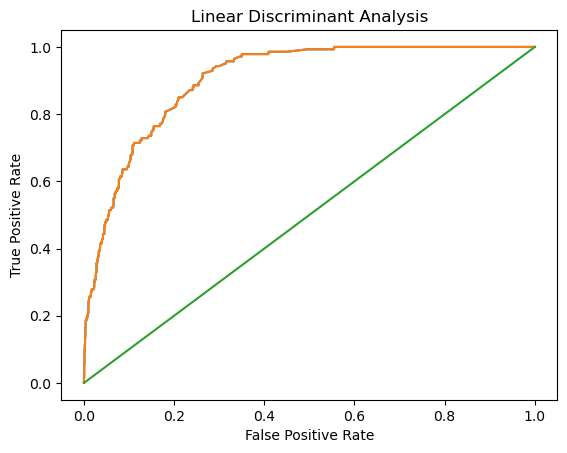

In [30]:
# ROC Curve 3
lda_predictions = lda_classifier.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, lda_predictions[:, 1])
plt.plot(fpr, tpr)
plt.plot(fpr, tpr, fpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear Discriminant Analysis')

# AUC score
lda_auc = roc_auc_score(y_test, lda_predictions[:, 1])

In [235]:
# Tuning to find the best hyperparameters
param_grid_lda = {
    'shrinkage': [None, 'auto', 0.01, 0.1, 0.5, 0.9],  # Shrinkage parameter
    'solver': ['lsqr', 'eigen']  # Shrinkage requires 'lsqr' or 'eigen' solver
}
grid_search_lda = GridSearchCV(lda_classifier, param_grid_lda, cv=3, scoring='accuracy', n_jobs=-1)

grid_search_lda.fit(X_train_undersampled, y_train_undersampled)

best_params_lda = grid_search_lda.best_params_

In [166]:
best_params_lda

{'shrinkage': 0.1, 'solver': 'lsqr'}

In [213]:
# train the model with best params and 3-fold cv
lda_best = LinearDiscriminantAnalysis(**best_params)

lda_scores = cross_val_score(lda_best, X_train_undersampled, y_train_undersampled, cv=3, scoring='accuracy')

print("Cross-validated scores:", lda_scores)
print("Average score:", lda_scores.mean())

Cross-validated scores: [0.76612903 0.80376344 0.84139785]
Average score: 0.803763440860215


## Decision Tree Classifier

In [160]:
# 4). Decision tree analysis
dtree = DecisionTreeClassifier()
dtree.fit(X_train_undersampled, y_train_undersampled)
dtree_score = dtree.score(x_test, y_test)

In [161]:
dtree_score

0.8044469783352337

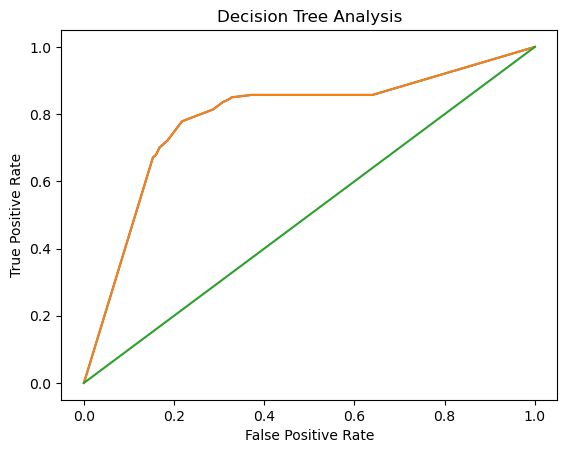

In [34]:
# ROC Curve 5
dtree_predictions = dtree.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, dtree_predictions[:, 1])
plt.plot(fpr, tpr)
plt.plot(fpr, tpr, fpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Analysis')

# AUC score
dtree_auc = roc_auc_score(y_test, dtree_predictions[:, 1])

In [134]:
# Tuning to find the best params
param_grid = {
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],   
}

dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_undersampled, y_train_undersampled)
best_params_dt = grid_search.best_params_

In [135]:
best_params_dt

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10}

In [212]:
# train model with 3-fold cv and best params
dt_best = DecisionTreeClassifier(**best_params_dt, random_state=42)
dtree_scores = cross_val_score(dt_best, X_train_undersampled, y_train_undersampled, cv=3, scoring='accuracy')

print("Cross-validated scores:", dtree_scores)
print("Average score:", dtree_scores.mean())

Cross-validated scores: [0.73655914 0.77688172 0.80107527]
Average score: 0.771505376344086


## 30-NN Classifier

In [163]:
# 5a). KNN Classifier 30
knn30 = KNeighborsClassifier(n_neighbors=30)
knn30.fit(X_train_undersampled, y_train_undersampled)
knn30_score = knn30.score(x_test, y_test)

C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [164]:
knn30_score

0.8722919042189282

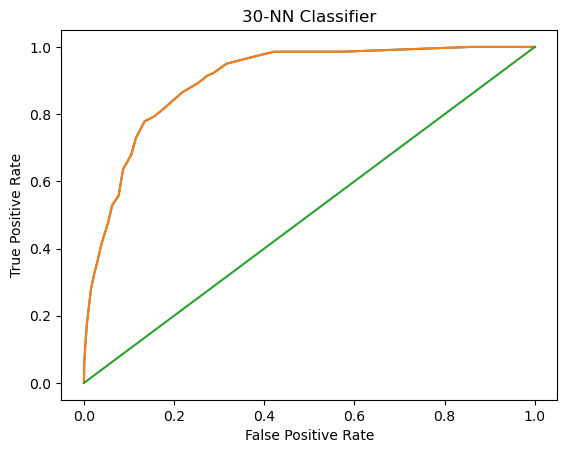

In [190]:
# ROC Curve 5a
knn30_predictions = knn30.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, knn30_predictions[:, 1])
plt.plot(fpr, tpr)
plt.plot(fpr, tpr, fpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('30-NN Classifier')

# AUC score
knn30_auc = roc_auc_score(y_test, knn30_predictions[:, 1])

In [176]:
# tuning
param_grid_nn = {
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan', 'minkowski'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
}

grid_search_30nn = GridSearchCV(knn30, param_grid_nn, cv=3, scoring='accuracy', n_jobs=-1)

grid_search_30nn.fit(X_train_undersampled, y_train_undersampled)

best_params_30nn = grid_search_30nn.best_params_

In [177]:
best_params_30nn

{'algorithm': 'auto', 'metric': 'manhattan', 'weights': 'distance'}

In [211]:
# train the model with best params and 3-fold cv
knn30_best = KNeighborsClassifier(n_neighbors=30, **best_params_30nn)

# Perform 3-fold cross-validation
knn30_scores = cross_val_score(knn30_best, X_train_undersampled, y_train_undersampled, cv=3, scoring='accuracy')

print("Cross-validated scores:", knn30_scores)
print("Average score:", knn30_scores.mean())

Cross-validated scores: [0.75537634 0.7688172  0.77956989]
Average score: 0.767921146953405


## 50-NN Classifier

In [183]:
# 5b). KNN Classifier 50
knn50 = KNeighborsClassifier(n_neighbors=50)
knn50.fit(X_train_undersampled, y_train_undersampled)
knn50_score = knn50.score(x_test, y_test)

C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [41]:
knn50_score

0.8779931584948689

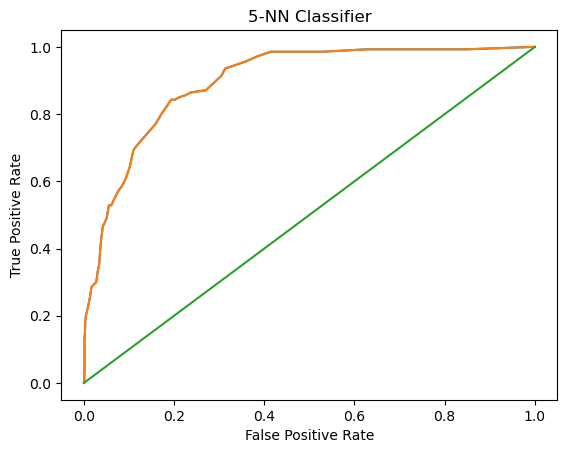

In [42]:
# ROC Curve 5b
knn50_predictions = knn50.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, knn50_predictions[:, 1])
plt.plot(fpr, tpr)
plt.plot(fpr, tpr, fpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5-NN Classifier')

# AUC score
knn50_auc = roc_auc_score(y_test, knn50_predictions[:, 1])

In [195]:
# tuning
grid_search_50nn = GridSearchCV(knn50, param_grid_nn, cv=3, scoring='accuracy', n_jobs=-1)

grid_search_50nn.fit(X_train_undersampled, y_train_undersampled)

best_params_50nn = grid_search_50nn.best_params_

In [196]:
best_params_50nn

{'algorithm': 'auto', 'metric': 'manhattan', 'weights': 'distance'}

In [210]:
# train the model with best params and 3-fold cv
knn50_best = KNeighborsClassifier(n_neighbors=50, **best_params_50nn)

# Perform 3-fold cross-validation
knn50_scores = cross_val_score(knn50_best, X_train_undersampled, y_train_undersampled, cv=3, scoring='accuracy')

print("Cross-validated scores:", knn50_scores)
print("Average score:", knn50_scores.mean())

Cross-validated scores: [0.75268817 0.75       0.77688172]
Average score: 0.7598566308243727


## 10-NN classifier

In [185]:
# 5c). KNN Classifier 10
knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train_undersampled, y_train_undersampled)
knn10_score = knn10.score(x_test, y_test)

C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [186]:
knn10_score

0.8489167616875712

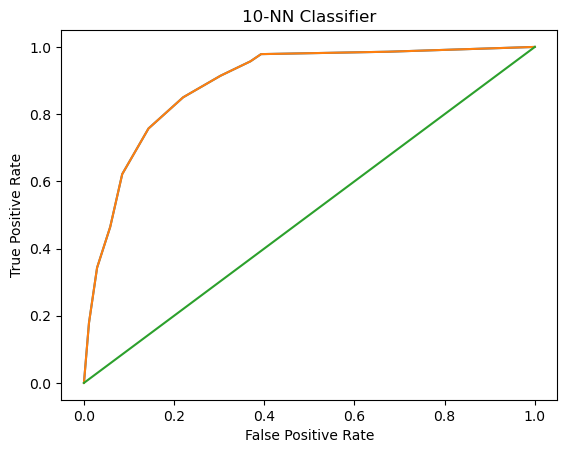

In [46]:
# ROC Curve 5c
knn10_predictions = knn10.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, knn10_predictions[:, 1])
plt.plot(fpr, tpr)
plt.plot(fpr, tpr, fpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10-NN Classifier')

# AUC score
knn10_auc = roc_auc_score(y_test, knn10_predictions[:, 1])

In [198]:
# tuning
grid_search_10nn = GridSearchCV(knn10, param_grid_nn, cv=3, scoring='accuracy', n_jobs=-1)

grid_search_10nn.fit(X_train_undersampled, y_train_undersampled)

best_params_10nn = grid_search_10nn.best_params_

In [199]:
best_params_10nn

{'algorithm': 'auto', 'metric': 'euclidean', 'weights': 'uniform'}

In [232]:
# train the model with best params and 3-fold cv
knn10_best = KNeighborsClassifier(n_neighbors=10, **best_params_10nn)

# Perform 3-fold cross-validation
knn10_scores = cross_val_score(knn10_best, X_train_undersampled, y_train_undersampled, cv=3, scoring='accuracy')

print("Cross-validated scores:", knn10_scores)
print("Average score:", knn10_scores.mean())

Cross-validated scores: [0.73655914 0.79569892 0.77688172]
Average score: 0.7697132616487455


C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

## Naive Bayes classifier

In [188]:
# 6). Naive Bayes CLassifier
naive = GaussianNB()
naive.fit(X_train_undersampled, y_train_undersampled)
naive_score = naive.score(x_test, y_test)

In [49]:
naive_score

0.8677309007981756

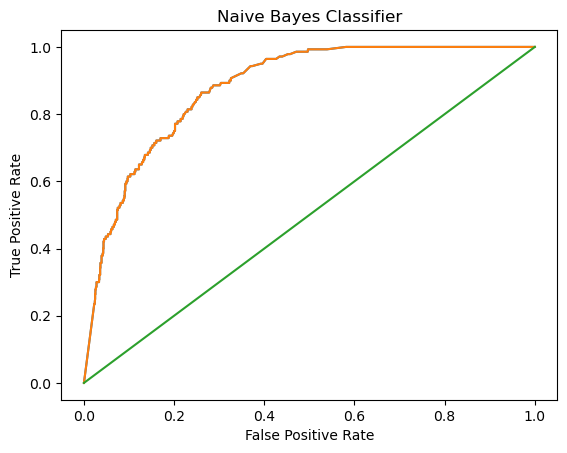

In [50]:
# ROC Curve 6
naive_predictions = naive.predict_proba(x_test)
fpr, tpr, threshold = roc_curve(y_test, naive_predictions[:, 1])
plt.plot(fpr, tpr)
plt.plot(fpr, tpr, fpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes Classifier')

# AUC score
naive_auc = roc_auc_score(y_test, naive_predictions[:, 1])

In [207]:
# 3-fold cv
naive_scores = cross_val_score(naive, X_train_undersampled, y_train_undersampled, cv=3, scoring='accuracy')

print("Cross-validated scores:", naive_scores)
print("Average score:", naive_scores.mean())

Cross-validated scores: [0.67204301 0.63978495 0.74193548]
Average score: 0.6845878136200717


## AUC of classifiers

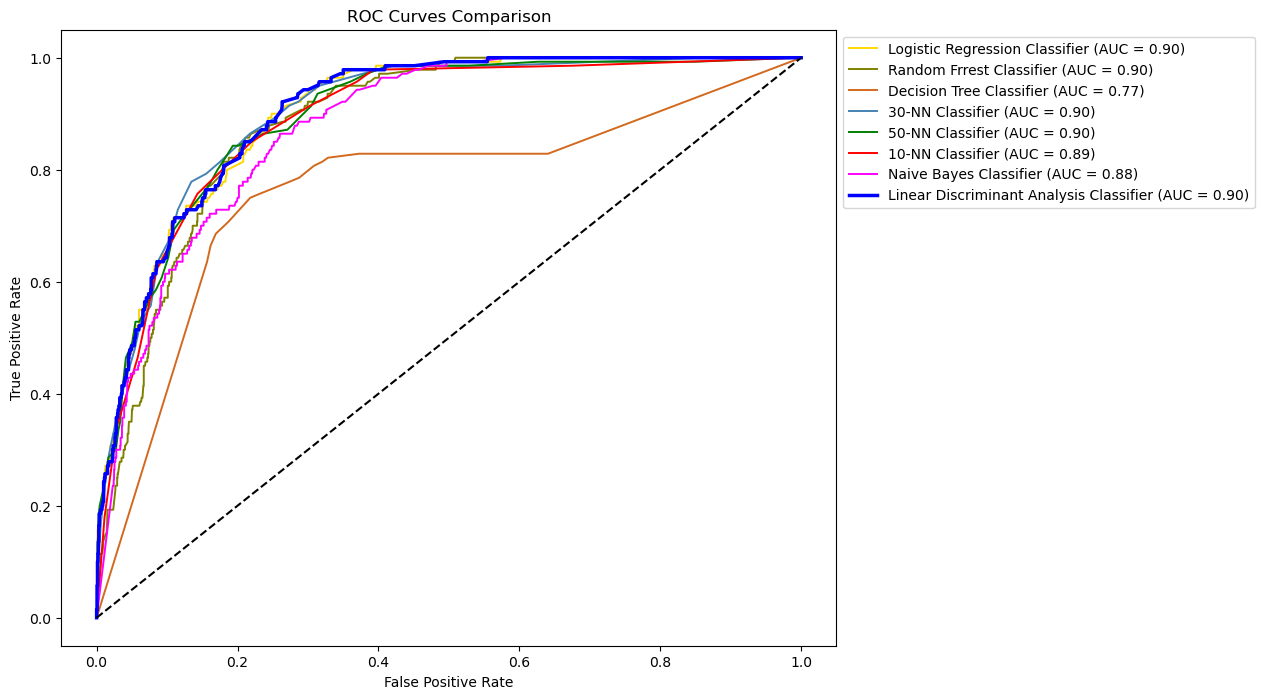

In [254]:
lr_predictions = logreg_classifier.predict_proba(x_test)[:, 1]
rf_predictions = rf_classifier.predict_proba(x_test)[:, 1]
lda_predictions = lda_classifier.predict_proba(x_test)[:, 1]
dtree_predictions = dtree.predict_proba(x_test)[:, 1]
knn30_predictions = knn30.predict_proba(x_test)[:, 1]
knn50_predictions = knn50.predict_proba(x_test)[:, 1]
knn10_predictions = knn10.predict_proba(x_test)[:, 1]
naive_predictions = naive.predict_proba(x_test)[:, 1]

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_predictions)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_predictions)
fpr_lda, tpr_lda, _ = roc_curve(y_test, lda_predictions)
fpr_dtree, tpr_dtree, _ = roc_curve(y_test, dtree_predictions)
fpr_30nn, tpr_30nn, _ = roc_curve(y_test, knn30_predictions)
fpr_50nn, tpr_50nn, _ = roc_curve(y_test, knn50_predictions)
fpr_10nn, tpr_10nn, _ = roc_curve(y_test, knn10_predictions)
fpr_naive, tpr_naive, _ = roc_curve(y_test, naive_predictions)

lr_auc = roc_auc_score(y_test, lr_predictions)
rf_auc = roc_auc_score(y_test, rf_predictions)
lda_auc = roc_auc_score(y_test, lda_predictions)
dtree_auc = roc_auc_score(y_test, dtree_predictions)
knn30_auc = roc_auc_score(y_test, knn30_predictions)
knn50_auc = roc_auc_score(y_test, knn50_predictions)
knn10_auc = roc_auc_score(y_test, knn10_predictions)
naive_auc = roc_auc_score(y_test, naive_predictions)

# Plot ROC curve for each classifier
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression Classifier (AUC = {lr_auc:.2f})', linewidth=1.4, color='gold')
plt.plot(fpr_rf, tpr_rf, label=f'Random Frrest Classifier (AUC = {lr_auc:.2f})', linewidth=1.4, color='olive')
plt.plot(fpr_dtree, tpr_dtree, label=f'Decision Tree Classifier (AUC = {dtree_auc:.2f})', linewidth=1.4, color='chocolate')
plt.plot(fpr_30nn, tpr_30nn, label=f'30-NN Classifier (AUC = {knn30_auc:.2f})', linewidth=1.4, color='steelblue')
plt.plot(fpr_50nn, tpr_50nn, label=f'50-NN Classifier (AUC = {knn50_auc:.2f})', linewidth=1.4, color='green')
plt.plot(fpr_10nn, tpr_10nn, label=f'10-NN Classifier (AUC = {knn10_auc:.2f})', linewidth=1.4, color='red')
plt.plot(fpr_naive, tpr_naive, label=f'Naive Bayes Classifier (AUC = {naive_auc:.2f})', linewidth=1.4, color='magenta')
plt.plot(fpr_lda, tpr_lda, label=f'Linear Discriminant Analysis Classifier (AUC = {lda_auc:.2f})', linewidth=2.5, color='blue')


# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Add axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')

# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

## AUC of tuned classifiers

# Confusion Matrix

In [219]:
# confusion matrix for KNN classifiers

def test_model(X_train_undersampled, y_train_undersampled, x_test, y_test, model_type, model_opts, plot_cm=False):
    
    # this is dict unrolling (just like with tuples, above)
    model = model_type(**model_opts)
    model.fit(X_train_undersampled, y_train_undersampled)

    res = dict()

    res["model"] = model
    
    res["score"] = model.score(x_test, y_test)
    
    cm = confusion_matrix(y_test, model.predict(x_test))
    disp = ConfusionMatrixDisplay(cm, display_labels=None)
    res["disp"] = disp
    if plot_cm: disp.plot()
        
    res["confusion_matrix"] = pd.DataFrame(
        cm, 
        index=["Actual Negative", "Actual Positive"], 
        columns=["Predicted Negative", "Predicted Positive"]
    )
    
    # False Positivity: False Positives / All Actual Negatives
    res["false_pos_rate"] = cm[0, 1]/cm[0].sum()    
    # Recall: True Positives / All Positives
    res["recall_rate"] = cm[1, 1]/cm[1].sum()

    return res

C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

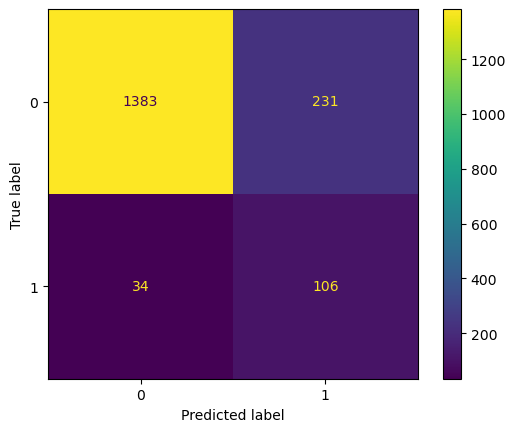

In [220]:
# 10-nn confusion matrix
res0 = test_model(X_train_undersampled, y_train_undersampled, x_test, y_test, 
                 KNeighborsClassifier, {"n_neighbors": 10}, plot_cm=True)

k10_fpr = res0['false_pos_rate']
k10_tpr = res0['recall_rate']

C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

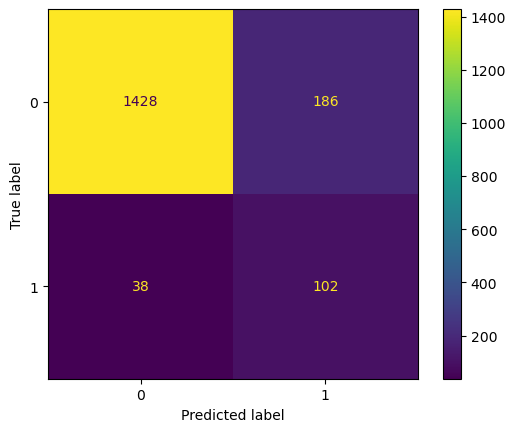

In [221]:
# 30-nn confusion matrix
res1 = test_model(X_train_undersampled, y_train_undersampled, x_test, y_test, 
                 KNeighborsClassifier, {"n_neighbors": 30}, plot_cm=True)

k30_fpr = res1['false_pos_rate']
k30_tpr = res1['recall_rate']

C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\amyc0\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

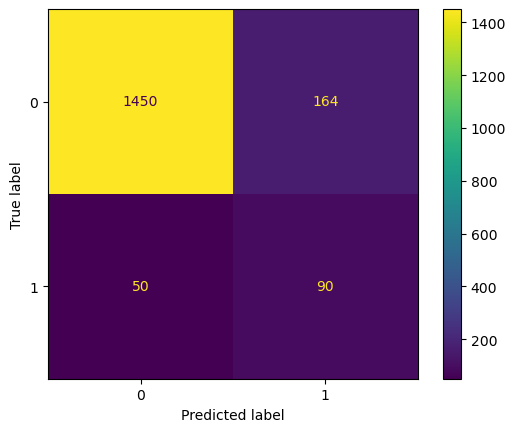

In [222]:
# 50-nn confusion matrix
res2 = test_model(X_train_undersampled, y_train_undersampled, x_test, y_test, 
                 KNeighborsClassifier, {"n_neighbors": 50}, plot_cm=True)

k50_fpr = res2['false_pos_rate']
k50_tpr = res2['recall_rate']

In [223]:
# confusion matrix for other classifiers

def test_model_other(X_train_undersampled, y_train_undersampled, x_test, y_test, model_type, plot_cm=False):
    
    # this is dict unrolling (just like with tuples, above)
    model = model_type()
    model.fit(X_train_undersampled, y_train_undersampled)

    res = dict()

    res["model"] = model
    
    res["score"] = model.score(x_test, y_test)
    
    cm = confusion_matrix(y_test, model.predict(x_test))
    disp = ConfusionMatrixDisplay(cm, display_labels=None)
    res["disp"] = disp
    if plot_cm: disp.plot()
        
    res["confusion_matrix"] = pd.DataFrame(
        cm, 
        index=["Actual Negative", "Actual Positive"], 
        columns=["Predicted Negative", "Predicted Positive"]
    )
    
    # False Positivity: False Positives / All Actual Negatives
    res["false_pos_rate"] = cm[0, 1]/cm[0].sum()    
    # Recall: True Positives / All Positives
    res["recall_rate"] = cm[1, 1]/cm[1].sum()

    return res

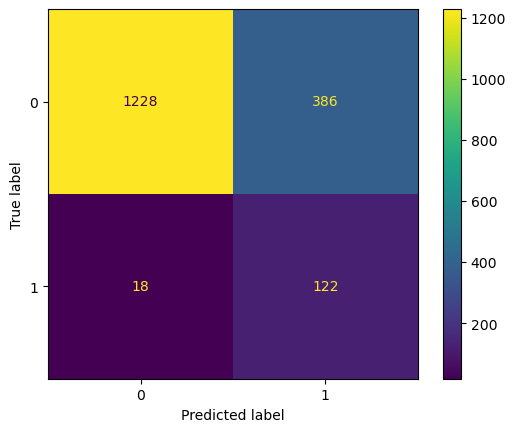

In [224]:
# Logistic regression cclassifier confusion matrix
res3 = test_model_other(X_train_undersampled, y_train_undersampled, x_test, y_test, 
                 LogisticRegression, plot_cm=True)

lr_fpr = res3['false_pos_rate']
lr_tpr = res3['recall_rate']

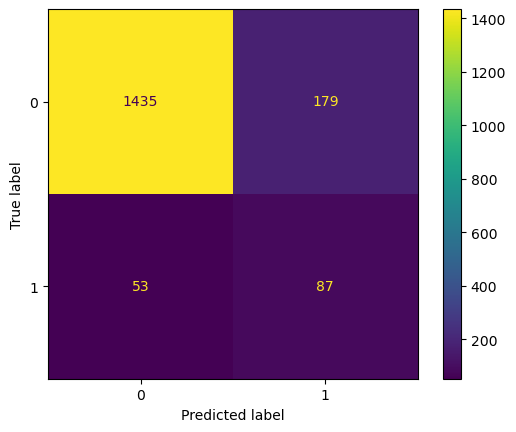

In [225]:
# Naive bayes classifier confusion matrix
res4 = test_model_other(X_train_undersampled, y_train_undersampled, x_test, y_test, 
                 GaussianNB, plot_cm=True)

naive_fpr = res4['false_pos_rate']
naive_tpr = res4['recall_rate']

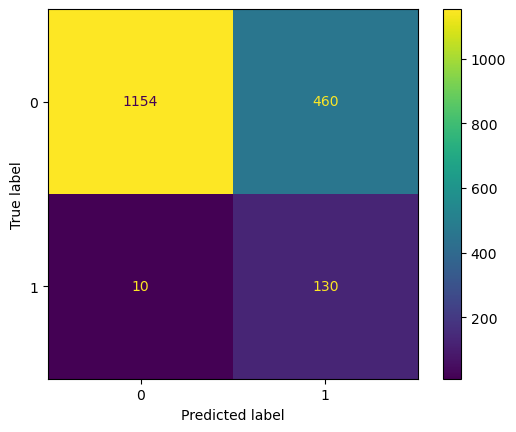

In [226]:
# linear discriminant analysis confusion matrix
res5 = test_model_other(X_train_undersampled, y_train_undersampled, x_test, y_test, 
                 LinearDiscriminantAnalysis, plot_cm=True)

lda_fpr = res5['false_pos_rate']
lda_tpr = res5['recall_rate']

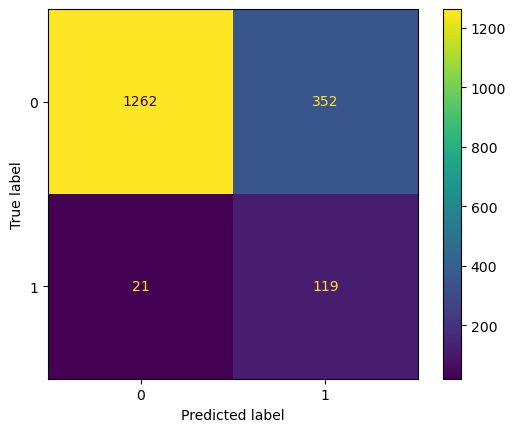

In [227]:
# random forest confusion matrix
res6 = test_model_other(X_train_undersampled, y_train_undersampled, x_test, y_test, 
                 RandomForestClassifier, plot_cm=True)

rf_fpr = res6['false_pos_rate']
rf_tpr = res6['recall_rate']

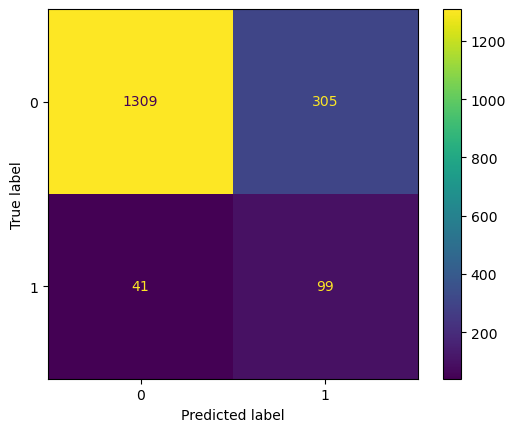

In [228]:
# decision tree confusion matrix
res7 = test_model_other(X_train_undersampled, y_train_undersampled, x_test, y_test, 
                 DecisionTreeClassifier, plot_cm=True)

dt_fpr = res7['false_pos_rate']
dt_tpr = res7['recall_rate']

# Results

In [242]:
# result table
results = pd.DataFrame([[logreg_score, log_scores.mean(), lr_auc, lr_tpr, lr_fpr],
                        [rf_score, rf_scores.mean(),rf_auc, rf_tpr, rf_fpr],
                        [lda_score, lda_scores.mean(),lda_auc, lda_tpr, lda_fpr],
                        [dtree_score, dtree_scores.mean(), dtree_auc, dt_tpr, dt_fpr],
                        [knn30_score, knn30_scores.mean(), knn30_auc, k30_tpr, k30_fpr],
                        [knn50_score, knn50_scores.mean(), knn50_auc, k50_tpr, k50_fpr],
                        [knn10_score, knn10_scores.mean(), knn10_auc, k10_tpr, k10_fpr],
                        [naive_score, naive_scores.mean(), naive_auc, naive_tpr, naive_fpr]], 
     index=['Logistic classifier:', 'Random forest classifier', 'Linear disriminant analysis', 
           'Decision tree classifier', '30-NN classifier', '50-NN classifier', 
            '10-NN classifier', 'Naive Bayes classifier'],
     columns=['Accuracy Rate', 'Tuned 3-Fold CV', 'AUC', 'TPR', 'FPR'])
results.sort_values(by='Accuracy Rate', ascending=False)

,Accuracy Rate,Tuned 3-Fold CV,AUC,TPR,FPR
50-NN classifier,0.877993,0.759857,0.897263,0.642857,0.101611
30-NN classifier,0.872292,0.767921,0.902846,0.728571,0.115242
Naive Bayes classifier,0.867731,0.684588,0.879308,0.621429,0.110905
10-NN classifier,0.848917,0.769713,0.891664,0.757143,0.143123
Decision tree classifier,0.804447,0.771505,0.789142,0.707143,0.188971
Random forest classifier,0.791904,0.792115,0.887365,0.850000,0.218092
Logistic classifier:,0.769669,0.799283,0.903445,0.871429,0.239157
Linear disriminant analysis,0.732041,0.803763,0.903976,0.928571,0.285006
